In [1]:
# Precipitation - inches (accumulation)  
# Temperature - Fahrenheit  
# Snow - Binary (0 - no snow, 1 - snow)
# Streamflow - ft³/s

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import random
import tensorflow as tf
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers.legacy import Adam

import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random

# Set global random seed for reproducibility
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Option to re-run the model, otherwise load the model from /models
RUN_MODEL = True

# Set global random seed for reproducibility
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Option to re-run the model, otherwise load the model from /models
RUN_MODEL = True

# Gather Data

,PREC_Avg,TAVG_Avg,soilmoisture_Avg_8ft,Snow,streamflow
date,,,,,
2008-03-12,26.00,24.80,17.74,1,2360.0
2008-03-15,26.55,17.55,17.88,1,2260.0
2008-03-17,26.70,19.35,18.04,1,2260.0
2008-03-18,26.70,17.85,18.06,1,2260.0
2008-03-19,26.70,25.50,18.06,1,2200.0
...,...,...,...,...,...
2021-07-23,24.20,57.50,14.60,0,1170.0
2021-07-24,24.40,55.85,14.38,0,1240.0
2021-07-25,24.65,55.15,14.24,0,1190.0


,PREC_Avg,TAVG_Avg,soilmoisture_Avg_8ft,Snow,streamflow,prec_year,prec_rolling,temp_rolling,soil_rolling,dayofyear,sin_dayofyear,cos_dayofyear
date,,,,,,,,,,,,
2008-03-18,26.70,17.85,18.06,1.0,2260.0,185.125,26.446429,20.050000,17.900000,78,0.974100,0.226116
2008-03-19,26.70,25.50,18.06,1.0,2200.0,211.825,26.546429,20.150000,17.945714,79,0.977848,0.209315
2008-03-20,26.70,26.60,18.10,1.0,1930.0,238.525,26.620238,20.752381,17.990476,80,0.981306,0.192452
2008-03-21,26.75,24.00,18.14,1.0,1780.0,265.275,26.675000,21.328571,18.034286,81,0.984474,0.175531
2008-03-22,26.75,17.75,18.04,1.0,1740.0,292.025,26.703571,21.357143,18.057143,82,0.987349,0.158559
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23,24.20,57.50,14.60,0.0,1170.0,3572.500,23.735714,60.271429,14.680000,204,-0.361714,-0.932289
2021-07-24,24.40,55.85,14.38,0.0,1240.0,3596.900,23.857143,59.914286,14.582857,205,-0.377708,-0.925925
2021-07-25,24.65,55.15,14.24,0.0,1190.0,3621.550,24.014286,58.785714,14.482857,206,-0.393590,-0.919286


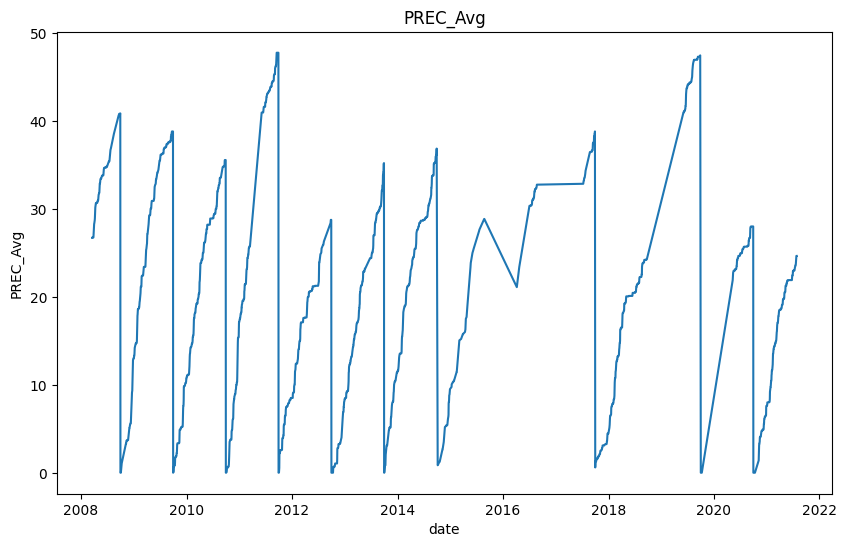

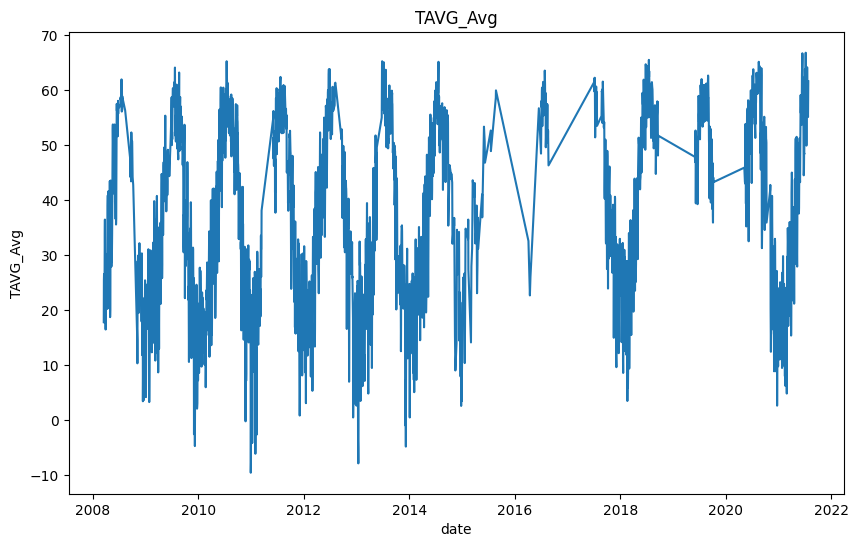

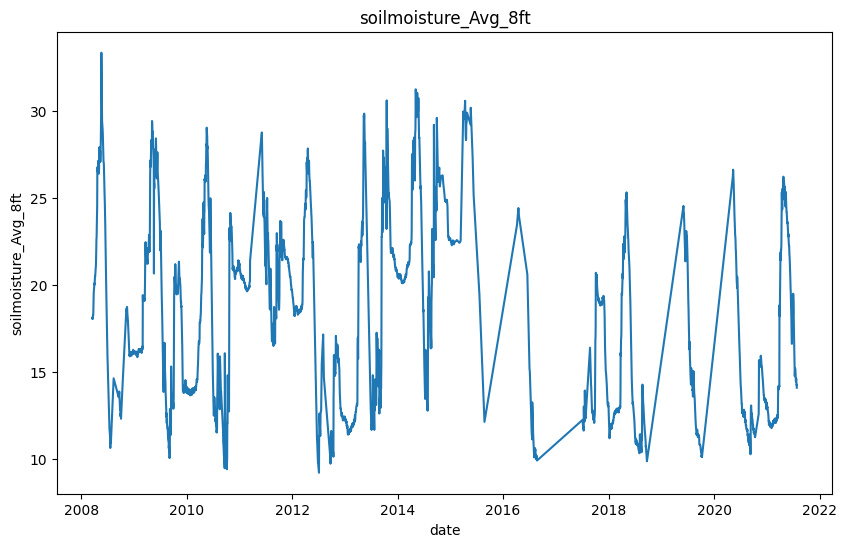

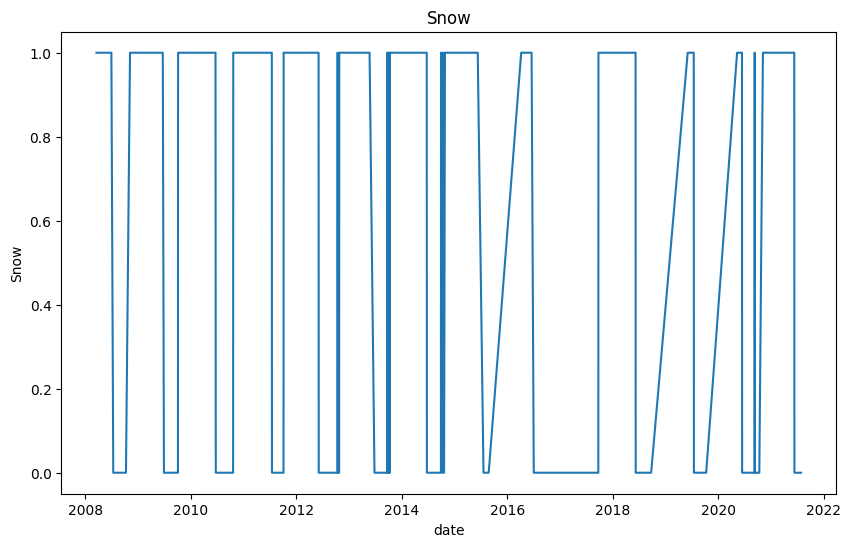

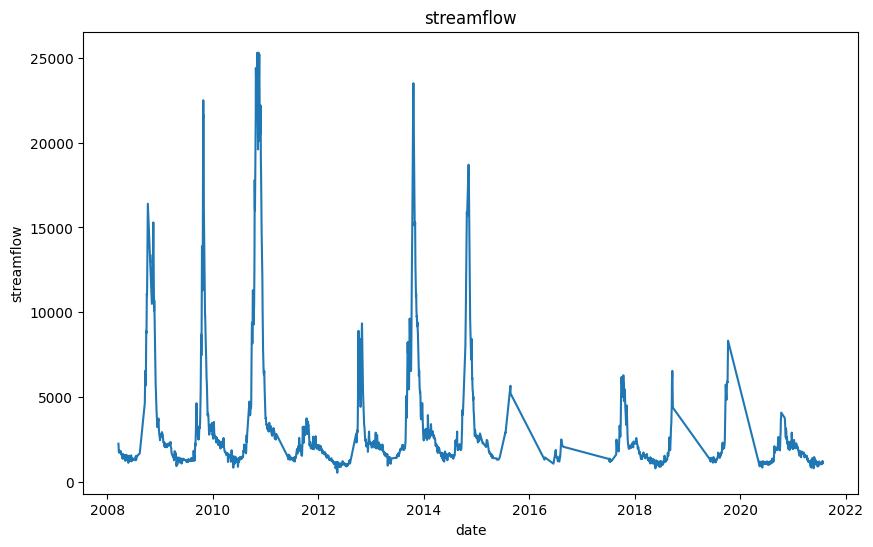

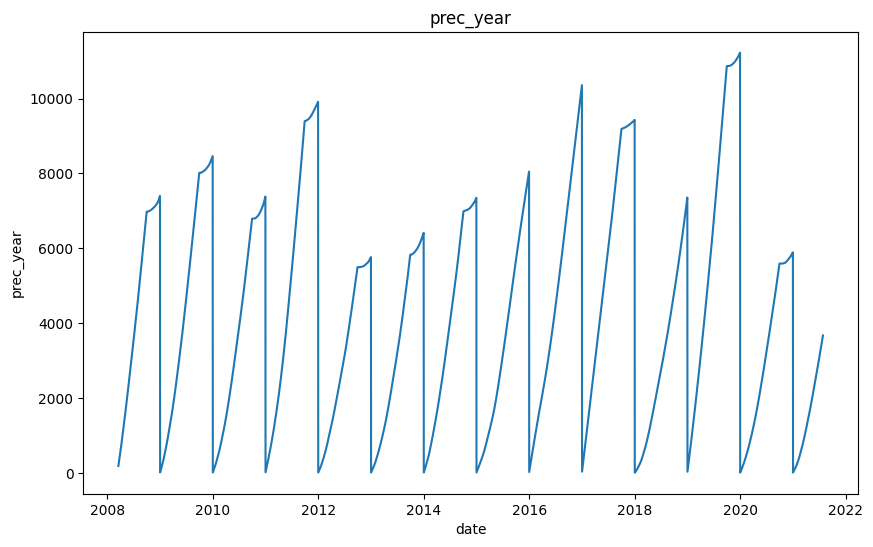

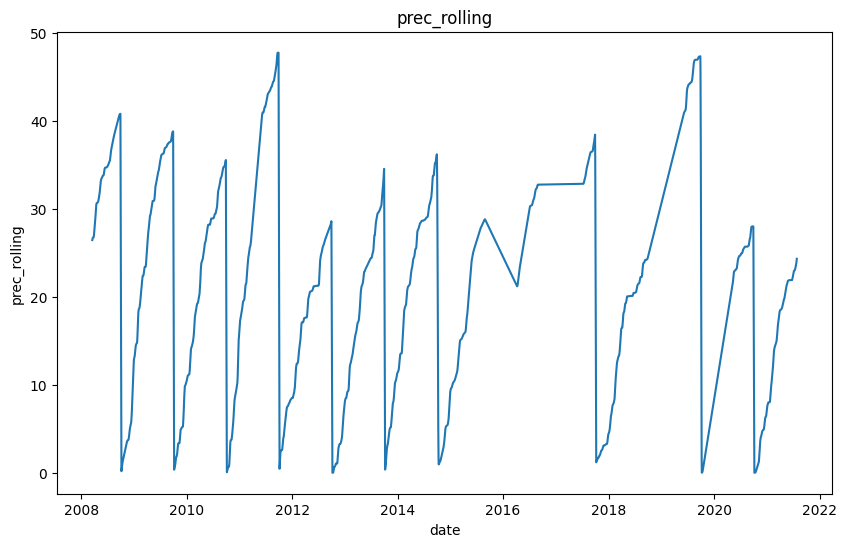

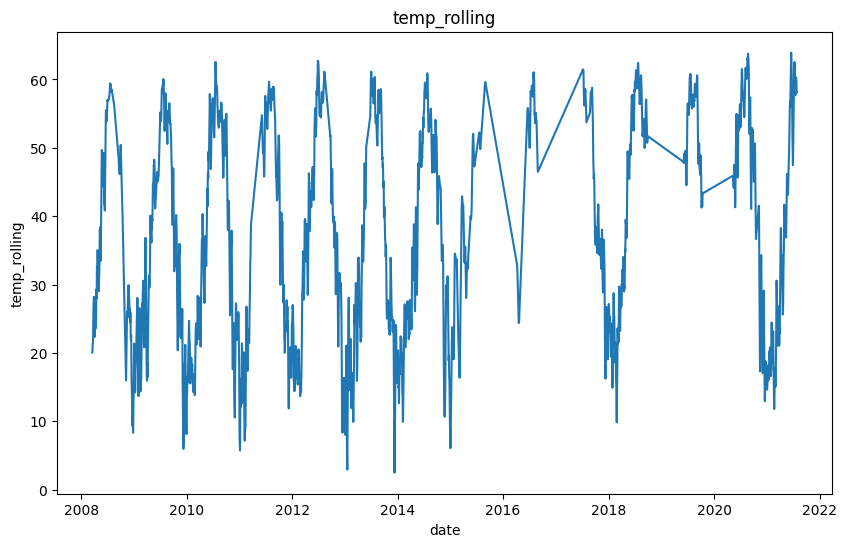

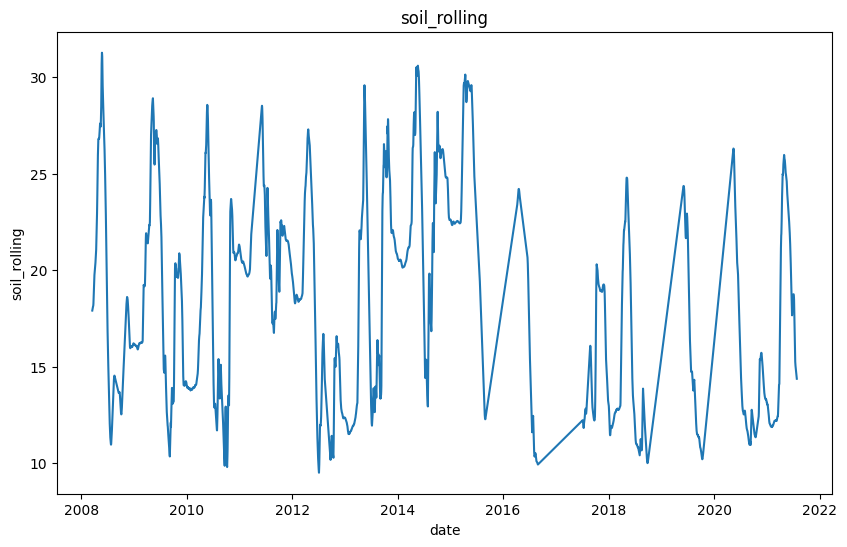

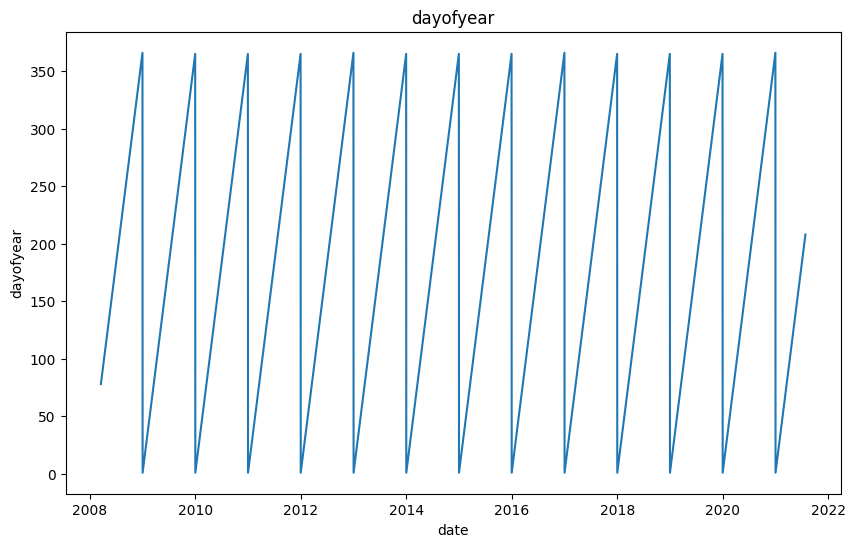

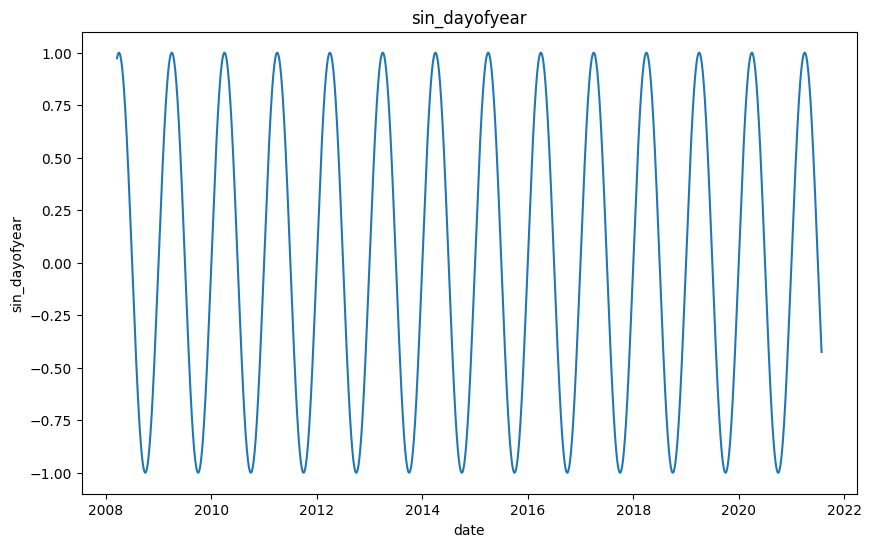

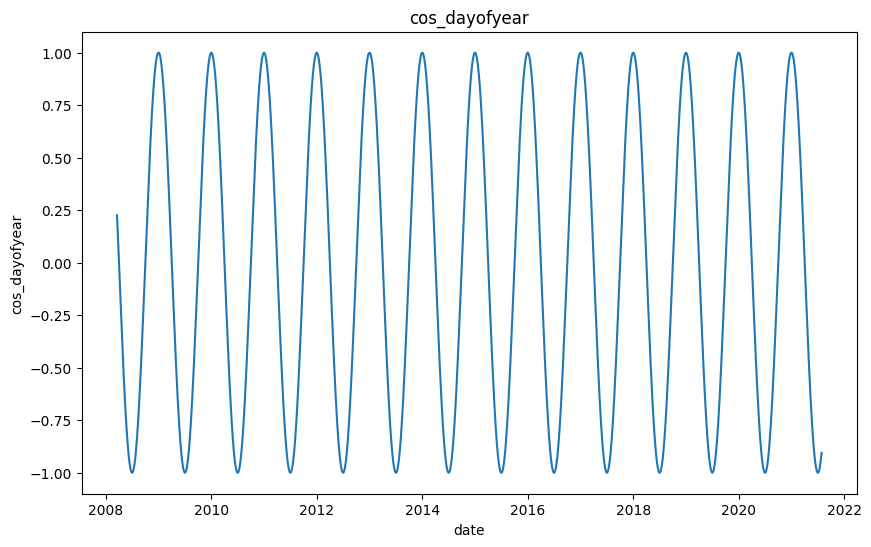

In [3]:
df = pd.read_csv('data/datasets/snow_soilmoisture_prediction_dataset.csv', index_col=0, parse_dates=True)
display(df)

# feature engineering
rolling_window = 7
df = df.asfreq('D').interpolate()
df['prec_year'] = df['PREC_Avg'].groupby(df.index.year).cumsum()
df['prec_rolling'] = df['PREC_Avg'].rolling(window=rolling_window).mean()
df['temp_rolling'] = df['TAVG_Avg'].rolling(window=rolling_window).mean()
df['soil_rolling'] = df['soilmoisture_Avg_8ft'].rolling(window=rolling_window).mean()
df['dayofyear'] = df.index.dayofyear
df['sin_dayofyear'] = np.sin(2*np.pi*df['dayofyear']/365)
df['cos_dayofyear'] = np.cos(2*np.pi*df['dayofyear']/365)

df = df.dropna()
display(df)

for feature in df.columns:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df.index, y=feature, data=df)
    plt.title(feature)
    plt.show()

# LSTM

Global scalers saved successfully.
Training on Split 1...
26/26 [==============================] - 0s 692us/step
Split 1 - RMSE: 4160.8270, MAE: 2016.5814


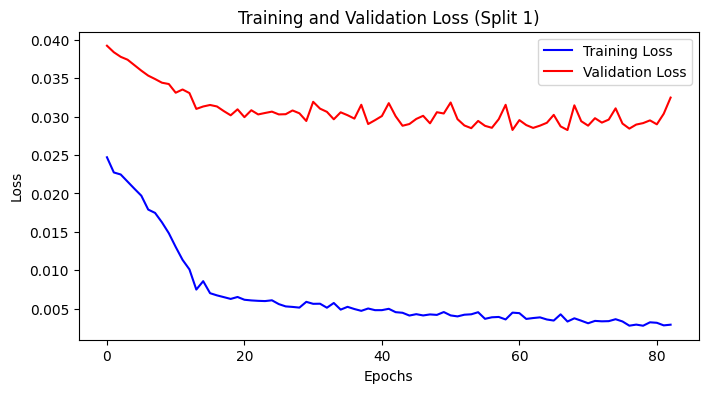

Model for Split 1 saved successfully.
Training on Split 2...
26/26 [==============================] - 0s 692us/step
Split 2 - RMSE: 2626.9774, MAE: 1469.3910


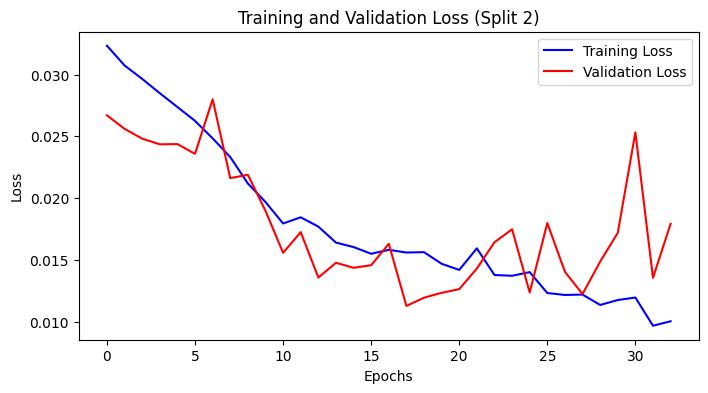

Model for Split 2 saved successfully.
Training on Split 3...
26/26 [==============================] - 0s 679us/step
Split 3 - RMSE: 1136.7066, MAE: 786.0593


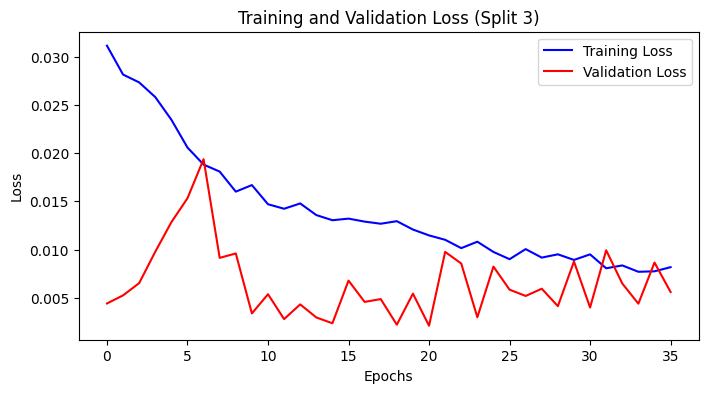

Model for Split 3 saved successfully.
Training on Split 4...
26/26 [==============================] - 0s 882us/step
Split 4 - RMSE: 624.5595, MAE: 409.4142


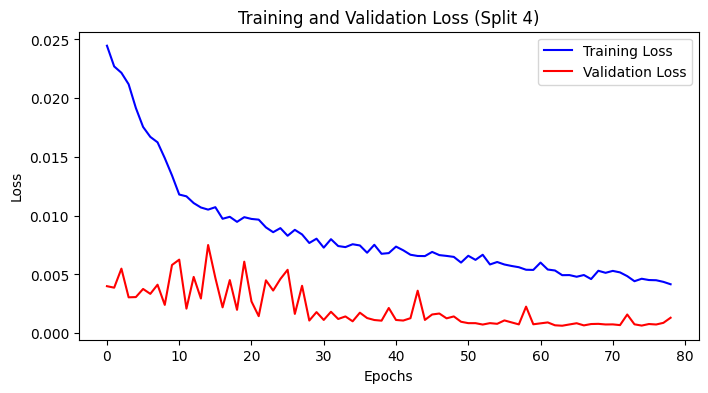

Model for Split 4 saved successfully.
Training on Split 5...
26/26 [==============================] - 0s 736us/step
Split 5 - RMSE: 1241.8549, MAE: 975.1915


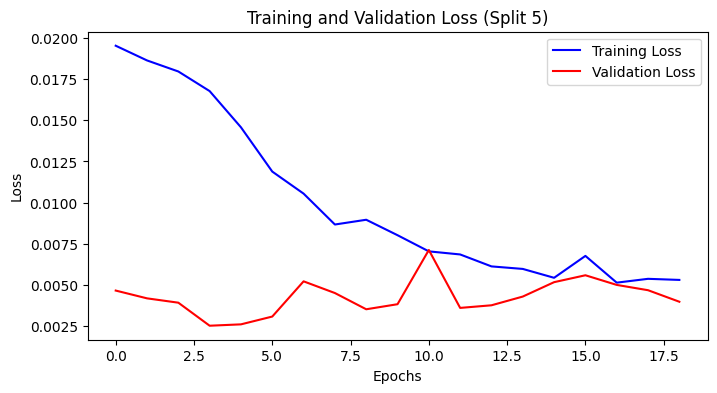

Model for Split 5 saved successfully.

Cross-Validation Ensemble Results:
Average RMSE: 1958.1851
Average MAE: 1131.3275

Generating Averaged Predictions Across All 5 Models...
Loading model fold 1...
153/153 [==============================] - 0s 985us/step
Loading model fold 2...
153/153 [==============================] - 0s 605us/step
Loading model fold 3...
153/153 [==============================] - 0s 609us/step
Loading model fold 4...
153/153 [==============================] - 0s 625us/step
Loading model fold 5...
153/153 [==============================] - 0s 619us/step
Predictions saved to 'data/predictions/streamflow_predictions.csv'.


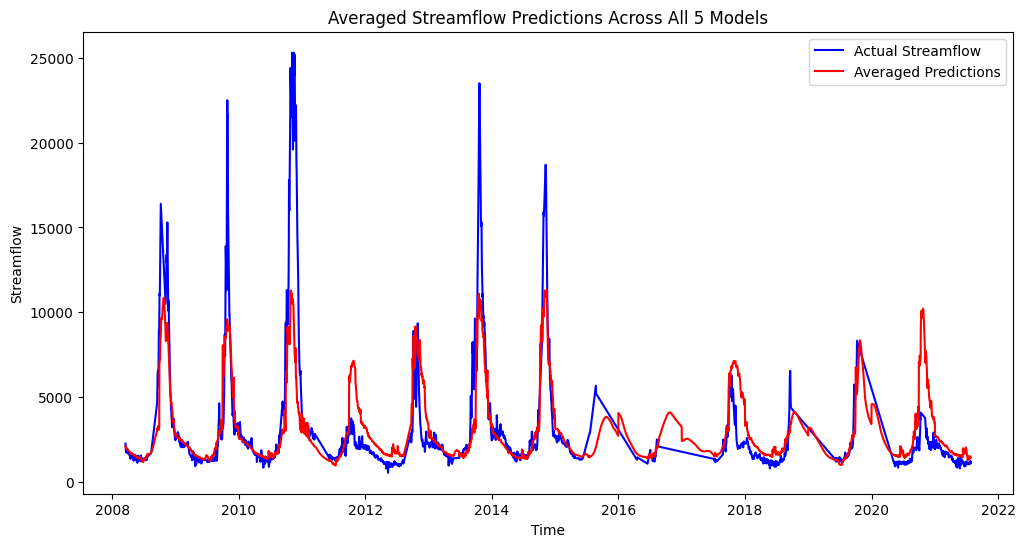


DataFrame with Streamflow Predictions:


,PREC_Avg,TAVG_Avg,soilmoisture_Avg_8ft,Snow,streamflow,prec_year,prec_rolling,temp_rolling,soil_rolling,dayofyear,sin_dayofyear,cos_dayofyear,streamflow_pred
date,,,,,,,,,,,,,
2008-03-18,26.70,17.85,18.06,1.0,2260.0,185.125,26.446429,20.050000,17.900000,78,0.974100,0.226116,2097.528809
2008-03-19,26.70,25.50,18.06,1.0,2200.0,211.825,26.546429,20.150000,17.945714,79,0.977848,0.209315,2069.220215
2008-03-20,26.70,26.60,18.10,1.0,1930.0,238.525,26.620238,20.752381,17.990476,80,0.981306,0.192452,2054.645752
2008-03-21,26.75,24.00,18.14,1.0,1780.0,265.275,26.675000,21.328571,18.034286,81,0.984474,0.175531,2046.221436
2008-03-22,26.75,17.75,18.04,1.0,1740.0,292.025,26.703571,21.357143,18.057143,82,0.987349,0.158559,2042.245361
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23,24.20,57.50,14.60,0.0,1170.0,3572.500,23.735714,60.271429,14.680000,204,-0.361714,-0.932289,1458.045898
2021-07-24,24.40,55.85,14.38,0.0,1240.0,3596.900,23.857143,59.914286,14.582857,205,-0.377708,-0.925925,1484.145752
2021-07-25,24.65,55.15,14.24,0.0,1190.0,3621.550,24.014286,58.785714,14.482857,206,-0.393590,-0.919286,1500.855957


In [4]:
def define_lstm_model(input_shape):
    """Define an LSTM model."""
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def plot_loss(history, split_index):
    """Plot training and validation loss."""
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(f'Training and Validation Loss (Split {split_index})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def main():
    # Ensure the 'models' folder exists
    if not os.path.exists('models'):
        os.makedirs('models')

    # Pre-scale the entire dataset globally
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_raw = df.drop(columns=['streamflow'])  # Input features
    y_raw = df['streamflow']  # Target variable

    # Fit scalers on the entire dataset
    X_scaled = scaler_X.fit_transform(X_raw)
    y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

    # Save the global scalers for later use
    joblib.dump(scaler_X, 'models/scaler_X_global.pkl')
    joblib.dump(scaler_y, 'models/scaler_y_global.pkl')
    print("Global scalers saved successfully.")

    # Early stopping configuration
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Time Series Split Configuration
    tscv = TimeSeriesSplit(n_splits=5)

    # Store metrics and predictions across all splits
    rmse_list, mae_list = [], []
    all_preds, all_actuals = [], []

    # Loop through each split in TimeSeriesSplit
    for split_index, (train_index, test_index) in enumerate(tscv.split(X_scaled), start=1):
        print(f"Training on Split {split_index}...")

        # Train-test split using pre-scaled data
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]

        # Reshape for LSTM input
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Define and train LSTM model
        model = define_lstm_model(input_shape=(X_train.shape[1], 1))
        history = model.fit(
            X_train, y_train, epochs=100, verbose=0, batch_size=32,
            validation_data=(X_test, y_test), callbacks=[early_stopping]
        )

        # Predict and store results
        y_pred = model.predict(X_test)
        y_pred_rescaled = scaler_y.inverse_transform(y_pred)
        y_test_rescaled = scaler_y.inverse_transform(y_test)

        all_preds.extend(y_pred_rescaled.flatten())
        all_actuals.extend(y_test_rescaled.flatten())

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
        mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
        rmse_list.append(rmse)
        mae_list.append(mae)
        print(f"Split {split_index} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

        # Plot training and validation loss
        plot_loss(history, split_index)

        # Save the model
        model.save(f"models/lstm_model_fold{split_index}.keras")
        print(f"Model for Split {split_index} saved successfully.")

    # Combine all predictions and actuals
    final_preds = np.array(all_preds)
    final_actuals = np.array(all_actuals)

    # Calculate overall metrics
    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)
    print("\nCross-Validation Ensemble Results:")
    print(f"Average RMSE: {avg_rmse:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")
    
    # Averaged Predictions from All 5 Models
    print("\nGenerating Averaged Predictions Across All 5 Models...")

    # Reshape the entire dataset for LSTM input
    X_full = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

    # Placeholder for predictions from all models
    full_preds = []

    # Load all 5 trained models and predict on the entire dataset
    for i in range(1, 6):  # Assuming 5 splits
        print(f"Loading model fold {i}...")
        model = tf.keras.models.load_model(f"models/lstm_model_fold{i}.keras")

        # Predict on the full dataset
        y_pred = model.predict(X_full)
        y_pred_rescaled = scaler_y.inverse_transform(y_pred)

        full_preds.append(y_pred_rescaled.flatten())  # Store predictions

    # Average the predictions across all models
    averaged_preds = np.mean(full_preds, axis=0)

    # Add averaged predictions to the original DataFrame
    df['streamflow_pred'] = averaged_preds

    # Save the updated DataFrame with predictions
    df.to_csv('data/predictions/streamflow_predictions.csv', index=True)
    print("Predictions saved to 'data/predictions/streamflow_predictions.csv'.")

    # Plot actual vs averaged predictions
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['streamflow'], label='Actual Streamflow', color='blue')
    plt.plot(df.index, df['streamflow_pred'], label='Averaged Predictions', color='red')
    plt.title('Averaged Streamflow Predictions Across All 5 Models')
    plt.xlabel('Time')
    plt.ylabel('Streamflow')
    plt.legend()
    plt.show()

    # Display the DataFrame with predictions
    print("\nDataFrame with Streamflow Predictions:")
    display(df)

if RUN_MODEL:
    main()

# Predict with RCP Scenarios

In [5]:
df_rcp45 = pd.read_csv(
    'data/predictions/rcp45_snow_rf_soilmoisture_lstm_predictions.csv', index_col=0, parse_dates=True)
df_rcp85 = pd.read_csv(
    'data/predictions/rcp85_snow_rf_soilmoisture_lstm_predictions.csv', index_col=0, parse_dates=True)

# add same features
df_rcp45['prec_year'] = df_rcp45['PREC_Avg'].groupby(df_rcp45.index.year).cumsum()
df_rcp45['prec_rolling'] = df_rcp45['PREC_Avg'].rolling(window=30).mean()
df_rcp45['temp_rolling'] = df_rcp45['TAVG_Avg'].rolling(window=30).mean()
df_rcp45['soil_rolling'] = df_rcp45['soilmoisture_Avg_8ft'].rolling(window=30).mean()
df_rcp45['dayofyear'] = df_rcp45.index.dayofyear
df_rcp45['sin_dayofyear'] = np.sin(2*np.pi*df_rcp45['dayofyear']/365)
df_rcp45['cos_dayofyear'] = np.cos(2*np.pi*df_rcp45['dayofyear']/365)

df_rcp85['prec_year'] = df_rcp85['PREC_Avg'].groupby(df_rcp85.index.year).cumsum()
df_rcp85['prec_rolling'] = df_rcp85['PREC_Avg'].rolling(window=30).mean()
df_rcp85['temp_rolling'] = df_rcp85['TAVG_Avg'].rolling(window=30).mean()
df_rcp85['soil_rolling'] = df_rcp85['soilmoisture_Avg_8ft'].rolling(window=30).mean()
df_rcp85['dayofyear'] = df_rcp85.index.dayofyear
df_rcp85['sin_dayofyear'] = np.sin(2*np.pi*df_rcp85['dayofyear']/365)
df_rcp85['cos_dayofyear'] = np.cos(2*np.pi*df_rcp85['dayofyear']/365)

df_rcp45 = df_rcp45.sort_index().reindex(columns=df.columns)
df_rcp85 = df_rcp85.sort_index().reindex(columns=df.columns)
df_rcp45 = df_rcp45.dropna(subset=['prec_rolling', 'temp_rolling', 'soil_rolling'])
df_rcp85 = df_rcp85.dropna(subset=['prec_rolling', 'temp_rolling', 'soil_rolling'])
display(df_rcp45, df_rcp85)

,PREC_Avg,TAVG_Avg,soilmoisture_Avg_8ft,Snow,streamflow,prec_year,prec_rolling,temp_rolling,soil_rolling,dayofyear,sin_dayofyear,cos_dayofyear,streamflow_pred
time,,,,,,,,,,,,,
2006-01-30 12:00:00,2.592942,16.299992,17.351016,1,NaN,44.493768,1.483126,23.223791,14.436170,30,4.937756e-01,0.869589,NaN
2006-01-31 12:00:00,2.592942,27.272213,17.322869,1,NaN,47.086710,1.569400,23.096730,14.706932,31,5.086709e-01,0.860961,NaN
2006-02-01 12:00:00,2.593391,31.274729,17.074762,1,NaN,49.680101,1.645637,23.393285,14.969424,32,5.234156e-01,0.852078,NaN
2006-02-02 12:00:00,2.594664,24.935026,16.870588,1,NaN,52.274765,1.720172,23.573343,15.225111,33,5.380052e-01,0.842942,NaN
2006-02-03 12:00:00,2.601046,21.481874,16.697251,1,NaN,54.875811,1.794919,23.830469,15.475019,34,5.524353e-01,0.833556,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27 12:00:00,27.937475,39.995155,25.947626,1,NaN,5896.129146,27.894015,36.885914,25.248856,361,-6.880243e-02,0.997630,NaN
2100-12-28 12:00:00,27.938652,35.275560,25.833564,1,NaN,5924.067798,27.896113,37.214156,25.241393,362,-5.161967e-02,0.998667,NaN
2100-12-29 12:00:00,27.938660,28.253563,25.831460,1,NaN,5952.006458,27.898210,37.133476,25.243655,363,-3.442161e-02,0.999407,NaN


,PREC_Avg,TAVG_Avg,soilmoisture_Avg_8ft,Snow,streamflow,prec_year,prec_rolling,temp_rolling,soil_rolling,dayofyear,sin_dayofyear,cos_dayofyear,streamflow_pred
time,,,,,,,,,,,,,
2006-01-30 12:00:00,2.239401,28.573797,15.959198,1,NaN,42.871709,1.429057,21.981437,13.816520,30,4.937756e-01,0.869589,NaN
2006-01-31 12:00:00,2.239407,32.932182,16.151044,1,NaN,45.111116,1.503557,22.042566,14.048222,31,5.086709e-01,0.860961,NaN
2006-02-01 12:00:00,2.247728,28.678800,16.308308,1,NaN,47.358844,1.568231,22.252132,14.285165,32,5.234156e-01,0.852078,NaN
2006-02-02 12:00:00,2.247747,30.933344,16.383022,1,NaN,49.606591,1.631189,22.631842,14.524599,33,5.380052e-01,0.842942,NaN
2006-02-03 12:00:00,2.248361,39.262460,16.583585,1,NaN,51.854952,1.694167,23.481412,14.770719,34,5.524353e-01,0.833556,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27 12:00:00,32.626354,40.788258,25.361338,1,NaN,6348.835813,32.161526,38.291567,25.926905,361,-6.880243e-02,0.997630,NaN
2100-12-28 12:00:00,32.643470,40.686527,25.366339,1,NaN,6381.479283,32.193288,38.194772,25.899159,362,-5.161967e-02,0.998667,NaN
2100-12-29 12:00:00,32.649437,37.635570,25.386576,1,NaN,6414.128720,32.225226,37.931623,25.872653,363,-3.442161e-02,0.999407,NaN


In [6]:
from keras.models import load_model

# Load global scalers
scaler_X = joblib.load('models/scaler_X_global.pkl')
scaler_y = joblib.load('models/scaler_y_global.pkl')

# Scale RCP datasets using the global input scaler
try:
    df_rcp45_scaled = scaler_X.transform(df_rcp45.drop(columns=['streamflow', 'streamflow_pred']))
    df_rcp85_scaled = scaler_X.transform(df_rcp85.drop(columns=['streamflow', 'streamflow_pred']))
except:
    df_rcp45_scaled = scaler_X.transform(df_rcp45.drop(columns=['streamflow']))
    df_rcp85_scaled = scaler_X.transform(df_rcp85.drop(columns=['streamflow']))  

# Placeholder for RCP predictions
rcp45_preds = []
rcp85_preds = []

# Load models and predict
for i in range(1, 6):  # Assuming 5 splits
    print(f"Predicting with model fold {i}...")

    # Load the trained model
    model = load_model(f"models/lstm_model_fold{i}.keras")

    # Reshape RCP data for LSTM input
    X_rcp45 = df_rcp45_scaled.reshape((df_rcp45_scaled.shape[0], df_rcp45_scaled.shape[1], 1))
    X_rcp85 = df_rcp85_scaled.reshape((df_rcp85_scaled.shape[0], df_rcp85_scaled.shape[1], 1))

    # Predict and inverse transform
    rcp45_pred = model.predict(X_rcp45)
    rcp85_pred = model.predict(X_rcp85)

    rcp45_preds.append(scaler_y.inverse_transform(rcp45_pred).flatten())
    rcp85_preds.append(scaler_y.inverse_transform(rcp85_pred).flatten())

# Average Predictions Across All Models
rcp45_streamflow_pred_rescaled = np.mean(rcp45_preds, axis=0)
rcp85_streamflow_pred_rescaled = np.mean(rcp85_preds, axis=0)

Predicting with model fold 1...
1084/1084 [==============================] - 1s 569us/step
Predicting with model fold 2...
1084/1084 [==============================] - 1s 578us/step
Predicting with model fold 3...
1084/1084 [==============================] - 1s 571us/step
Predicting with model fold 4...
1084/1084 [==============================] - 1s 552us/step
Predicting with model fold 5...
1084/1084 [==============================] - 1s 569us/step


In [7]:
# final dataset
df_rcp45['streamflow'] = rcp45_streamflow_pred_rescaled
df_rcp85['streamflow'] = rcp85_streamflow_pred_rescaled
df_rcp45.to_csv('data/predictions/rcp45_streamflow_listm_predictions.csv')
df_rcp85.to_csv('data/predictions/rcp85_streamflow_listm_predictions.csv')

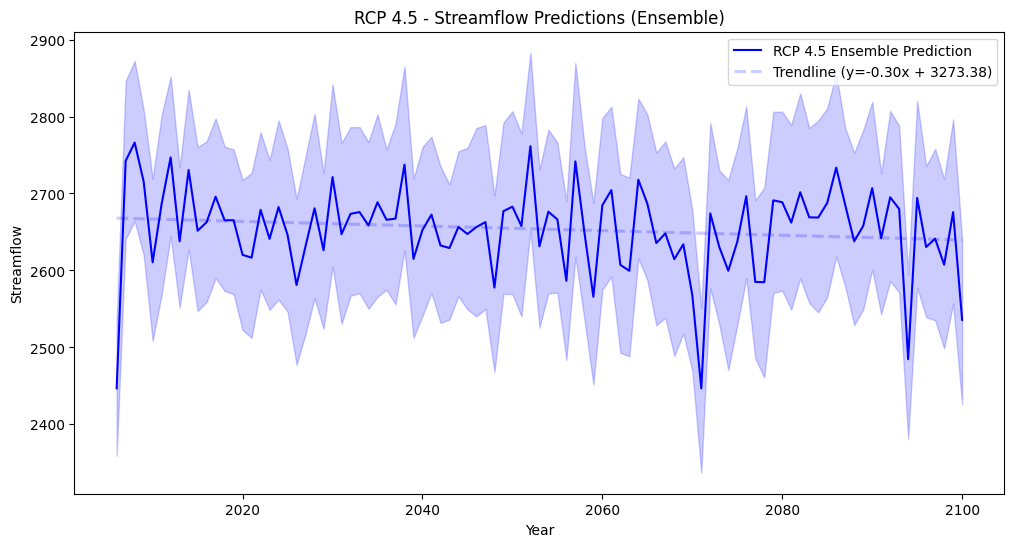

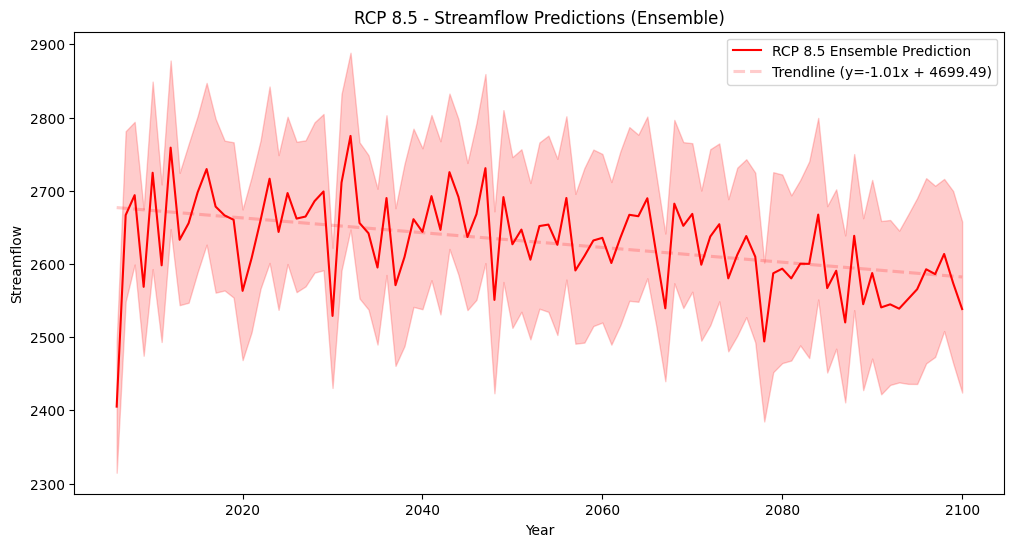

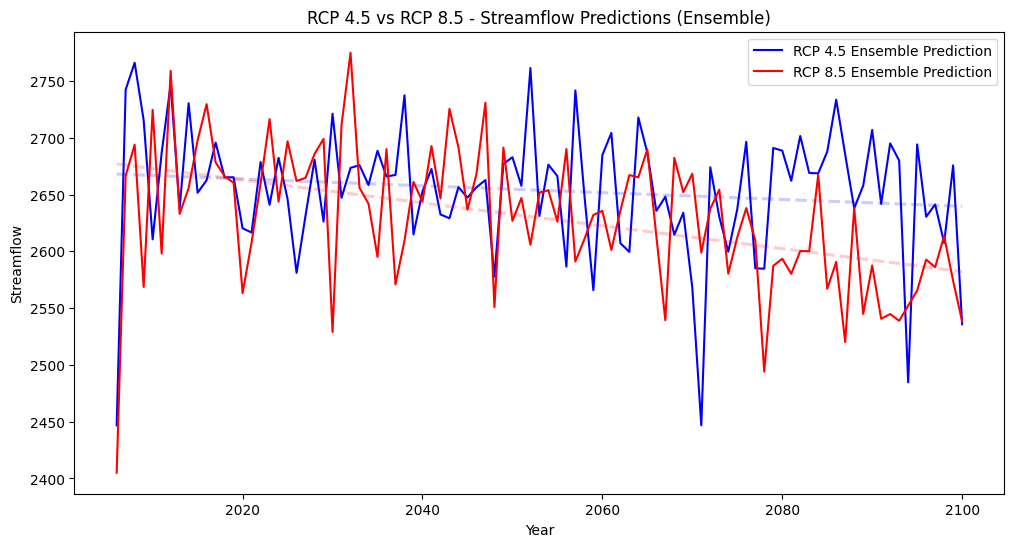

/var/folders/cj/3zyd4jkj3s1f2bnvnnc629300000gn/T/ipykernel_84198/919624553.py:59: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_rcp45_yearly = df_rcp45.resample('Y').agg({
/var/folders/cj/3zyd4jkj3s1f2bnvnnc629300000gn/T/ipykernel_84198/919624553.py:65: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_rcp85_yearly = df_rcp85.resample('Y').agg({


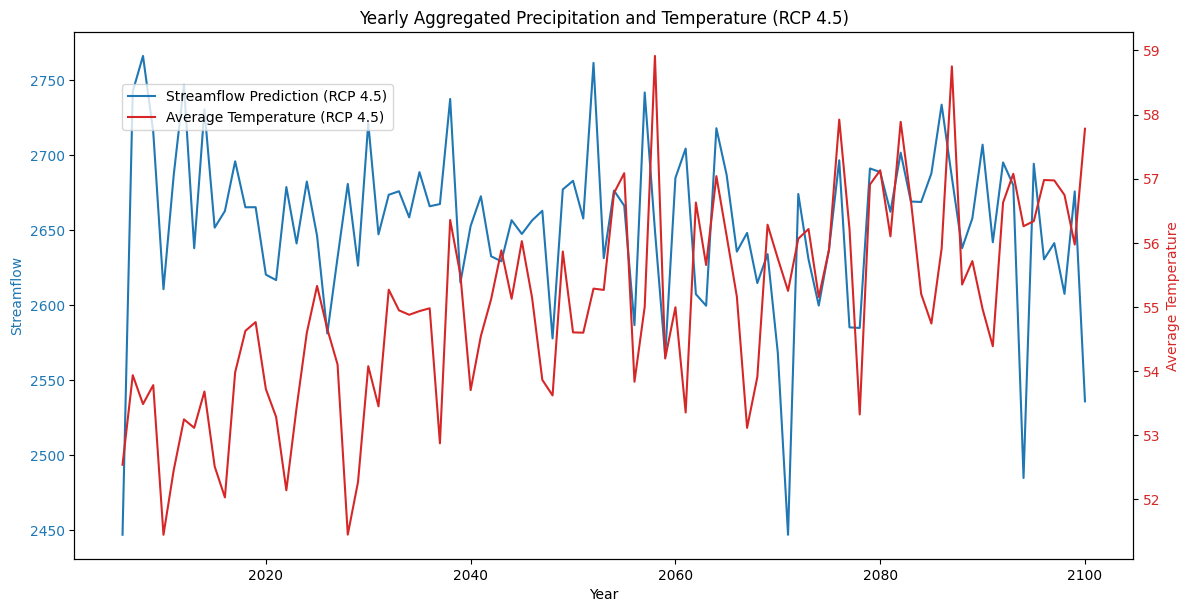

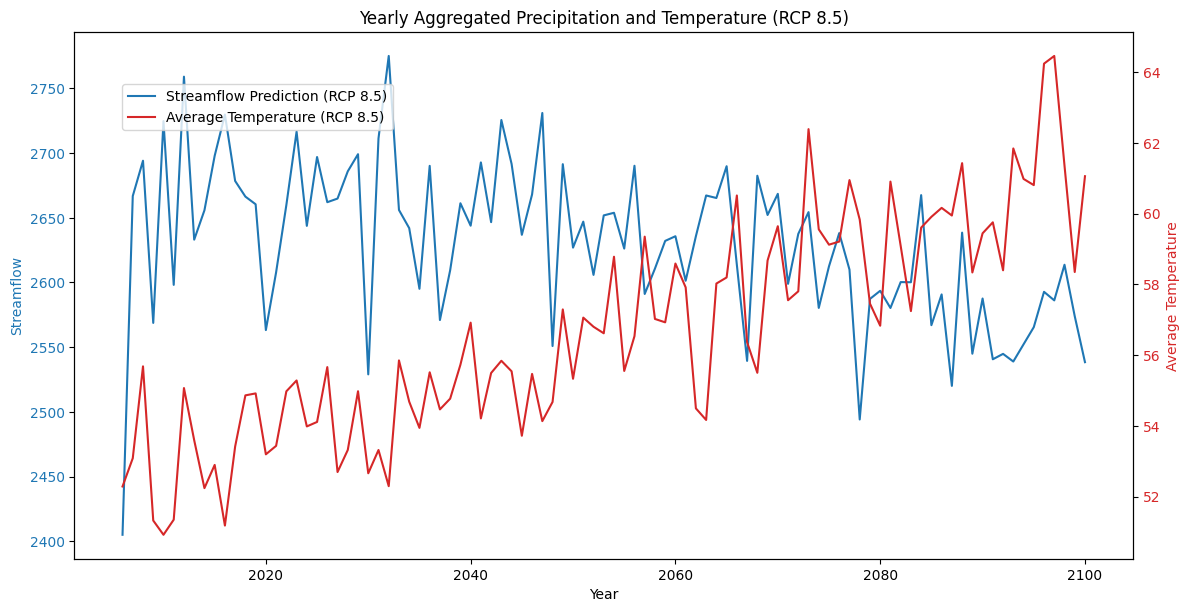

In [8]:
# Ensure x-axis is a flat numeric array
x_years_rcp45 = df_rcp45.index.year.to_numpy()
x_years_rcp85 = df_rcp85.index.year.to_numpy()

# Calculate trendline for RCP 4.5
slope_rcp45, intercept_rcp45 = np.polyfit(
    x_years_rcp45, rcp45_streamflow_pred_rescaled, 1)
trendline_label_rcp45 = f'Trendline (y={slope_rcp45:.2f}x + {intercept_rcp45:.2f})'

# Plot Results for RCP 4.5
plt.figure(figsize=(12, 6))
sns.lineplot(x=x_years_rcp45, y=rcp45_streamflow_pred_rescaled,
             label='RCP 4.5 Ensemble Prediction', color='blue')
sns.regplot(x=x_years_rcp45, y=rcp45_streamflow_pred_rescaled, scatter=False,
            color='blue', label=trendline_label_rcp45, line_kws={'alpha': 0.2, 'linestyle': '--'}, ci=None)
plt.title('RCP 4.5 - Streamflow Predictions (Ensemble)')
plt.xlabel('Year')
plt.ylabel('Streamflow')
# plt.ylim(2300, 2900)
plt.legend()
plt.show()

# Calculate trendline for RCP 8.5
slope_rcp85, intercept_rcp85 = np.polyfit(
    x_years_rcp85, rcp85_streamflow_pred_rescaled, 1)
trendline_label_rcp85 = f'Trendline (y={slope_rcp85:.2f}x + {intercept_rcp85:.2f})'

# Plot Results for RCP 8.5
plt.figure(figsize=(12, 6))
sns.lineplot(x=x_years_rcp85, y=rcp85_streamflow_pred_rescaled,
             label='RCP 8.5 Ensemble Prediction', color='red')
sns.regplot(x=x_years_rcp85, y=rcp85_streamflow_pred_rescaled, scatter=False,
            color='red', label=trendline_label_rcp85, line_kws={'alpha': 0.2, 'linestyle': '--'}, ci=None)
plt.title('RCP 8.5 - Streamflow Predictions (Ensemble)')
plt.xlabel('Year')
plt.ylabel('Streamflow')
# plt.ylim(2300, 2900)
plt.legend()
plt.show()

# Plot Results for Both RCPs
plt.figure(figsize=(12, 6))
sns.lineplot(x=x_years_rcp45, y=rcp45_streamflow_pred_rescaled,
             label='RCP 4.5 Ensemble Prediction', color='blue', errorbar=None)
sns.regplot(x=x_years_rcp45, y=rcp45_streamflow_pred_rescaled, scatter=False,
            color='blue', line_kws={'alpha': 0.2, 'linestyle': '--'}, ci=None)
sns.lineplot(x=x_years_rcp85, y=rcp85_streamflow_pred_rescaled,
                label='RCP 8.5 Ensemble Prediction', color='red', errorbar=None)
sns.regplot(x=x_years_rcp85, y=rcp85_streamflow_pred_rescaled, scatter=False,
            color='red', line_kws={'alpha': 0.2, 'linestyle': '--'}, ci=None)
plt.title('RCP 4.5 vs RCP 8.5 - Streamflow Predictions (Ensemble)')
plt.xlabel('Year')
plt.ylabel('Streamflow')
# plt.ylim(2300, 2900)
plt.legend()
plt.show()

# Aggregate precipitation and temperature to yearly values
df_rcp45_yearly = df_rcp45.resample('Y').agg({
    'PREC_Avg': 'sum',
    'TAVG_Avg': 'mean',
    'streamflow': 'mean'
})

df_rcp85_yearly = df_rcp85.resample('Y').agg({
    'PREC_Avg': 'sum',
    'TAVG_Avg': 'mean',
    'streamflow': 'mean'
})

# Plot yearly aggregated precipitation and temperature for RCP 4.5
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Streamflow', color=color)
ax1.plot(df_rcp45_yearly.index.year, df_rcp45_yearly['streamflow'], label='Streamflow Prediction (RCP 4.5)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Temperature', color=color)
ax2.plot(df_rcp45_yearly.index.year, df_rcp45_yearly['TAVG_Avg'], label='Average Temperature (RCP 4.5)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Yearly Aggregated Precipitation and Temperature (RCP 4.5)')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

# Plot yearly aggregated precipitation and temperature for RCP 8.5
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Streamflow', color=color)
ax1.plot(df_rcp85_yearly.index.year, df_rcp85_yearly['streamflow'], label='Streamflow Prediction (RCP 8.5)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Temperature', color=color)
ax2.plot(df_rcp85_yearly.index.year, df_rcp85_yearly['TAVG_Avg'], label='Average Temperature (RCP 8.5)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Yearly Aggregated Precipitation and Temperature (RCP 8.5)')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()



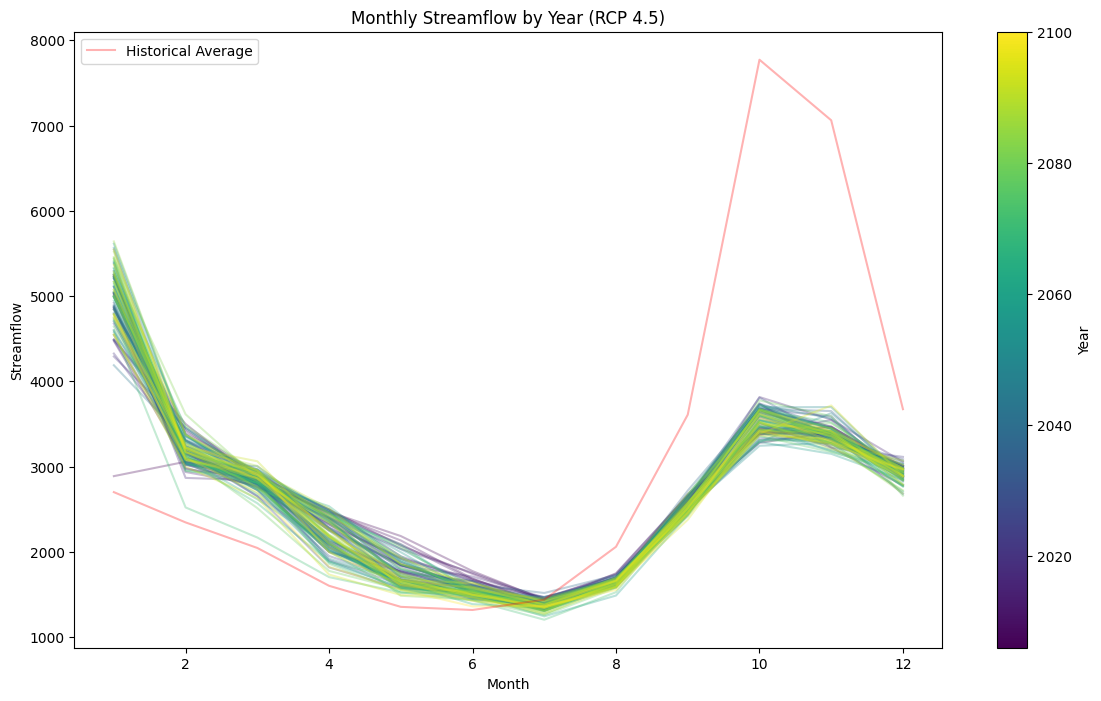

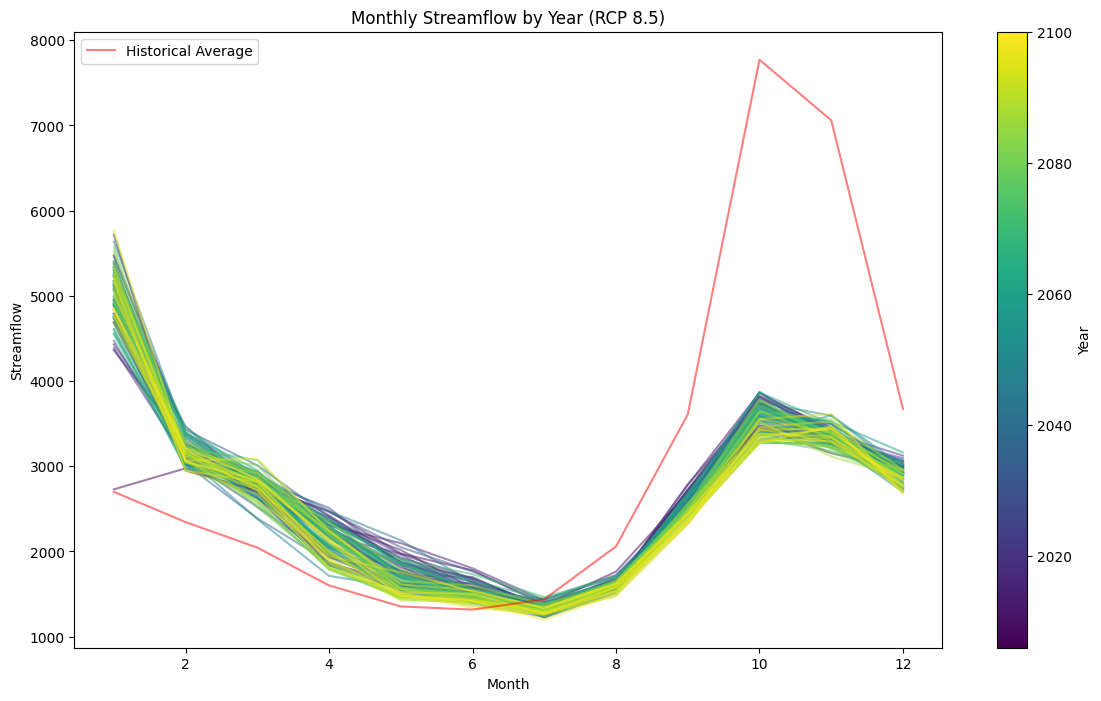

In [9]:
import matplotlib.colors as mcolors

# Extract year and month from the index
df_rcp45['Year'] = df_rcp45.index.year
df_rcp45['Month'] = df_rcp45.index.month

# Group by year and month, then calculate the mean streamflow for each month
monthly_streamflow_rcp45 = df_rcp45.groupby(['Year', 'Month'])['streamflow'].mean().unstack(level=0)

# Extract year and month from the historical data
df['Year'] = df.index.year
df['Month'] = df.index.month

# Calculate the average monthly streamflow for the historical data
monthly_streamflow_actual_avg = df.groupby('Month')['streamflow'].mean()

# Plot the data with color gradient
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_streamflow_rcp45.columns)))
for i, year in enumerate(monthly_streamflow_rcp45.columns):
    ax.plot(monthly_streamflow_rcp45.index, monthly_streamflow_rcp45[year], color=colors[i], alpha=0.3)

# Plot the average historical data
ax.plot(monthly_streamflow_actual_avg.index, monthly_streamflow_actual_avg, color='red', alpha=0.3, label='Historical Average')

ax.set_title('Monthly Streamflow by Year (RCP 4.5)')
ax.set_xlabel('Month')
ax.set_ylabel('Streamflow')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=monthly_streamflow_rcp45.columns.min(), vmax=monthly_streamflow_rcp45.columns.max()))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Year')
ax.legend()
plt.show()

# Extract year and month from the index
df_rcp85['Year'] = df_rcp85.index.year
df_rcp85['Month'] = df_rcp85.index.month

# Group by year and month, then calculate the mean streamflow for each month
monthly_streamflow_rcp85 = df_rcp85.groupby(['Year', 'Month'])['streamflow'].mean().unstack(level=0)

# Plot the data with color gradient
fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_streamflow_rcp85.columns)))
for i, year in enumerate(monthly_streamflow_rcp85.columns):
    ax.plot(monthly_streamflow_rcp85.index, monthly_streamflow_rcp85[year], color=colors[i], alpha=0.5)

# Plot the average historical data
ax.plot(monthly_streamflow_actual_avg.index, monthly_streamflow_actual_avg, color='red', alpha=0.5, label='Historical Average')

ax.set_title('Monthly Streamflow by Year (RCP 8.5)')
ax.set_xlabel('Month')
ax.set_ylabel('Streamflow')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=monthly_streamflow_rcp85.columns.min(), vmax=monthly_streamflow_rcp85.columns.max()))
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Year')
ax.legend()
plt.show()